The [Specialist Pharmacy Service](https://www.sps.nhs.uk/) is preparing guidance for CCGs, practices and others around delaying delaying administration of injectable medicines in primary care during the pandemic. This notebook sets out the prescribing of these medicines over the last decade.

Readers may find the ["What is a BNF code blog"](https://ebmdatalab.net/prescribing-data-bnf-codes/) useful reading for shortlisting some injections.

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
sql = '''
SELECT
    pct,
    CAST(month AS DATE) AS month,
    bnf.presentation,
    bnf_code,
    SUM(items) AS items,
    SUM(actual_cost) AS cost
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
INNER JOIN
  hscic.bnf as bnf
ON
  presc.bnf_code = bnf.presentation_code
WHERE
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM ebmdatalab.measures.dmd_objs_with_form_route
        WHERE 
        (form_route LIKE '%intravenous%' OR
        form_route LIKE'%injection%' OR
        form_route LIKE'%subcutaneous')      
        AND 
        bnf_code NOT LIKE "060101%"  #insulin out of scope
        AND
        bnf_code NOT LIKE "0304030C0%" #adrenaline out of scope
        AND
        bnf_code NOT LIKE "140%" #vaccines out of scope
        )
GROUP BY pct, month, presentation, bnf_code
ORDER BY pct, month
'''

df_inj = bq.cached_read(sql, csv_path=os.path.join('..','data', 'df_inj.zip'))
df_inj['month'] = df_inj['month'].astype('datetime64[ns]')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df_inj.head()

,pct,month,presentation,bnf_code,items,cost
0,00C,2010-08-01,Depixol-Conc_Inj 100mg/ml 1ml Amp,0402020G0BBADAB,2,33.90
1,00C,2010-08-01,Prostap 3_Depot Inj 11.25mg Vl + Dil Pfs,0803042N0BBABAB,7,1454.03
2,00C,2010-08-01,"Tinzaparin Sod_Inj 20,000u/ml 0.5ml Pfs",0208010W0AAAKAK,1,233.58
3,00C,2010-08-01,Genotropin MiniQuick_Inj 600mcg Pfs Cart,0605010S0BBAMAW,1,358.46
4,00C,2010-08-01,Methylpred Acet/Lidoc_Inj 40/10mg/1ml Vl,1001022K0AAAGAG,1,3.02


(0, 854659.4)

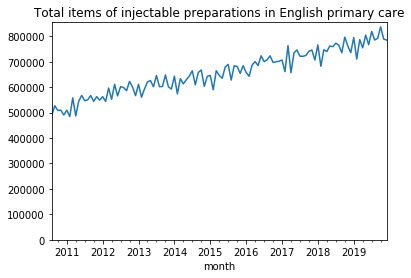

In [4]:
df_inj.groupby("month")['items'].sum().plot(kind='line', title="Total items of injectable preparations in English primary care")
plt.ylim(0, )

In [5]:
df_inj.nunique()

pct                 191
month               113
presentation       1825
bnf_code           1825
items              3078
cost            1247804
dtype: int64

In [6]:
df_inj["presentation"].unique()

array(['Depixol-Conc_Inj 100mg/ml 1ml Amp',
       'Prostap 3_Depot Inj 11.25mg Vl + Dil Pfs',
       'Tinzaparin Sod_Inj 20,000u/ml 0.5ml Pfs', ...,
       'Flolan_Inj 1.5mg Vl + Dil (pH10.5)',
       'Berinert_Inf 1500u Vl + Dil',
       'Calsynar_Inj Soln M/D 200u/ml 2ml Vl'], dtype=object)

In [7]:
##groupby bnf name  to see largest volume in terms of items
df_products = df_inj.groupby(['bnf_code', 'presentation']).sum().reset_index().sort_values(by = 'items', ascending = False)
df_products.head(100)

,bnf_code,presentation,items,cost
1167,0901020N0AAABAB,Hydroxocobalamin_Inj 1mg/ml 1ml Amp,19014251,39116972.57
919,0703022M0BBABAB,Depo-Provera_Inj 150mg/ml 1ml Pfs,6120590,34389932.35
632,0601023ABAAAAAA,Liraglutide_Inj 6mg/ml 3ml PF Pen,2849761,272957302.76
916,0703022M0AAABAB,Medroxyprogest Acet_Inj 150mg/ml 1ml Pfs,2696965,15229604.95
1769,1502010J0AABUBU,Lido HCl_Inj 1% 2ml Amp,2412826,761314.95
1526,1001022K0BBAAAA,Depo-Medrone_Inj 40mg/1ml Vl,1469701,5912478.88
1768,1502010J0AABEBE,Lido HCl_Inj 2% 2ml Amp,1197559,443493.92
1709,1501041T0AAAAAA,Midazolam HCl_Inj 5mg/ml 2ml Amp,1177830,6853201.23
1530,1001022K0BBAGAG,Depo-Medrone/Lidoc_Inj 40/10mg/ml 1ml Vl,1158906,5129647.50
1538,1001022U0BCAAAB,Kenalog_Inj I/A I/M 40mg/ml 1ml Vl,1050635,1860742.93
